## ASTR496: Foundations of Data Science in Astronomy
Gautham Narayan
gsn@illinois.edu

### Midterm

In [1]:
# Q1: Maximum Likelihood Estimation for Stellar Parameters
# Estimating Temperature and Extinction from Multi-band Photometry

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import cm
import warnings
import autograd.numpy as np 
from autograd import grad, jacobian, hessian
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

#### **Problem Setup:**
#### - We observe a star in multiple photometric bands (B, V, R, I, J, H, K)
#### - We want to estimate: stellar temperature T and visual extinction A_V
#### - We assume we know the distance from e.g. Gaia (or fit for it separately)
####
#### **Model:**
#### For each filter λ, the observed magnitude is:
####
#### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
####
#### where:
#### - M_λ(T) = absolute magnitude in filter λ for temperature T
#### - d = distance in parsecs
#### - A_V = visual extinction
#### - R_λ = extinction coefficient for filter λ

### First, I have to give you a stellar model as a function of wavelength
### We'll use a Planck function i.e. a blackbody

In [2]:
def planck_function(wavelength, temperature):
    """
    Planck function for blackbody radiation
    wavelength in microns, temperature in Kelvin
    Returns relative flux (arbitrary units)
    """
    h = 6.626e-34  # Planck constant
    c = 3e8        # Speed of light
    k = 1.381e-23  # Boltzmann constant

    wl_m = wavelength * 1e-6  # Convert to meters

    # Planck function
    numerator = 2 * h * c**2
    denominator = wl_m**5 * (np.exp(h * c / (wl_m * k * temperature)) - 1)

    return numerator / denominator

### Next we need to define a photometric system - we'll use the Johnson(-Morgan) Kron-Cousins UBVRI filters and the reddening coefficients 
### and JHK for the IR, largely because you can look up the filter's effective wavelengths $\lambda_\text{eff}$ in microns and the reddening coefficients from something like Cardelli-Clayton-Mathis '89.

In [3]:
filters = {
    'B': {'lambda_eff': 0.44, 'R_lambda': 4.1},   # Blue
    'V': {'lambda_eff': 0.55, 'R_lambda': 3.1},   # Visual (reference)
    'R': {'lambda_eff': 0.64, 'R_lambda': 2.7},   # Red
    'I': {'lambda_eff': 0.79, 'R_lambda': 2.0},   # Near-IR
    'J': {'lambda_eff': 1.25, 'R_lambda': 0.9},   # IR
    'H': {'lambda_eff': 1.63, 'R_lambda': 0.6},   # IR
    'K': {'lambda_eff': 2.19, 'R_lambda': 0.4}    # IR
}

In [4]:
# here are some quick arrays of the filters, wavelengths and reddening coefficients.
filter_names = list(filters.keys())
wavelengths = np.array([filters[f]['lambda_eff'] for f in filter_names])
R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names])

print(f"Photometric filters: {filter_names}")
print(f"Effective wavelengths (μm): {wavelengths}")
print(f"Extinction coefficients R_λ: {R_lambda}")

Photometric filters: ['B', 'V', 'R', 'I', 'J', 'H', 'K']
Effective wavelengths (μm): [0.44 0.55 0.64 0.79 1.25 1.63 2.19]
Extinction coefficients R_λ: [4.1 3.1 2.7 2.  0.9 0.6 0.4]


### Next, we need to reate the magnitudes of a star, given the spectral model 
### While we are using the Planck function as an approximation, we'll tie the fluxes to the obsserved flux of the 
### Sun itself, with $T_\text{eff}= 5778$K, and $M_V = 4.83$ (remember the absolute magnitude is defined for a distance of 10pc).

In [5]:
# Create stellar atmosphere model
def stellar_magnitude(temperature, filter_name, reference_temp=5778):
    """
    Calculate absolute magnitude for a star of given temperature
    Simplified model based on Planck function + calibration
    """
    wl = filters[filter_name]['lambda_eff']

    # Get flux ratio compared to solar temperature
    flux_star = planck_function(wl, temperature)
    flux_sun = planck_function(wl, reference_temp)
    flux_ratio = flux_star / flux_sun

    # Convert to magnitude difference (Sun has M_V = 4.83)
    # Add wavelength-dependent correction for more realism
    solar_magnitude = 4.83 + 0.5 * (wl - 0.55)  # Rough color correction

    magnitude = solar_magnitude - 2.5 * np.log10(flux_ratio)

    return magnitude

### Q1. As a function of temperature (3000-10,000K in 1000K steps) determine the B-V color

In [6]:
# Test the model
temps = np.array([3000, 4000, 5000, 6000, 8000, 10000])
print(f"\nStellar atmosphere model colors:")
print(f"Temperature (K) | V magnitude | B-V color")
print(f"-" * 40)
for T in temps:
    V_mag = stellar_magnitude(T, 'V')
    B_mag = stellar_magnitude(T, 'B')
    print(f"{T:11.0f} | {V_mag:9.2f} | {B_mag - V_mag:7.2f}")


Stellar atmosphere model colors:
Temperature (K) | V magnitude | B-V color
----------------------------------------
       3000 |      9.40 |    1.08
       4000 |      7.03 |    0.48
       5000 |      5.60 |    0.13
       6000 |      4.65 |   -0.10
       8000 |      3.43 |   -0.38
      10000 |      2.68 |   -0.54


### Next, I'll give you the "Truth" and some synthetic stellar data, with the true magnitudes of this star in each band using my `stellar_magnitude` but with the reddening and distance correction applied (you're going to have to do this)

In [7]:
# Generate a test star
TRUE_TEMP = 6500  # K
TRUE_A_V = 0.8    # magnitudes
TRUE_DISTANCE = 100    # parsecs


synthetic_star =  {'B': {'magnitude': 12.379, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': 11.752, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': 11.579, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': 11.225, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': 10.602, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': 10.592, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': 10.888, 'error': 0.08, 'true_magnitude': 10.762}}

### Q2.  
### OK, you know the drill 
### define a function that gives you the model magnitudes of the star given the temperature, extinction and distance
### define the log-likelihood
### Use `scipy.optimize` to get the best fit parameters for this star using maximum likelihood estimation
### Calculate the goodness of fit i.e. reduced chi-squared
### Calculate the Inverse Hessian Matrix and report the simple uncertainties on each parameter
### Which parameters are correlated strongly?

In [8]:
def model_magnitude(temperature, A_V, distance_pc, filter_name):
    """
    Model predicted magnitude for given parameters
    """
    M_abs = stellar_magnitude(temperature, filter_name)
    distance_modulus = 5 * np.log10(distance_pc / 10.0)
    extinction = A_V * filters[filter_name]['R_lambda']
    return M_abs + distance_modulus + extinction
    

def log_likelihood(params, observations):
    """
    Calculate log-likelihood for given parameters
    
    Parameters:
    params: [temperature, A_V, distance]
    observations: Dictionary of observations per filter
    distance_pc: Known distance in parsecs
    
    Returns:
    log-likelihood value
    """
    temperature, A_V, distance_pc = params
    
    # Physical constraints
    if temperature < 2000 or temperature > 50000:
        return -np.inf
    if A_V < 0 or A_V > 5.0:  # Reasonable extinction range
        return -np.inf
    if distance_pc <= 0 or distance_pc >= 500:
        return -np.inf
        
    log_L = 0.0
    
    for filter_name in observations.keys():
        # Predicted magnitude
        m_pred = model_magnitude(temperature, A_V, distance_pc, filter_name)
        
        # Observed magnitude and error
        m_obs = observations[filter_name]['magnitude']
        sigma = observations[filter_name]['error']
        
        # Gaussian likelihood contribution
        chi_sq_term = (m_obs - m_pred)**2 / (2 * sigma**2)
        # you don't need the normalization for inference if sigma is constant
        # but since I made the sigmas band-dependent, you will want these 
        normalization = np.log(sigma * np.sqrt(2 * np.pi))
        
        log_L -= chi_sq_term + normalization
    
    return log_L
    

def negative_log_likelihood(params, observations):
    """
    Negative log-likelihood for minimization
    """
    return -log_likelihood(params, observations)

In [9]:
# Initial guess
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance

# Minimize negative log-likelihood
result = minimize(
    negative_log_likelihood,
    initial_guess,
    args=(synthetic_star,),
    method='Nelder-Mead',
    options={'disp': False}
)

print(result)
# Extract results
fitted_temp, fitted_A_V, fitted_distance = result.x
max_log_likelihood = -result.fun

# Calculate goodness of fit
chi_squared = 0
for filter_name in filter_names:
    m_pred = model_magnitude(fitted_temp, fitted_A_V, fitted_distance, filter_name)
    m_obs = synthetic_star[filter_name]['magnitude']
    sigma = synthetic_star[filter_name]['error']
    chi_squared += ((m_obs - m_pred)**2) / sigma**2

n_data = len(filter_names)
n_params = 3 #temp, A_V, distance
reduced_chi_sq = chi_squared / (n_data - n_params)

# Calculate uncertainties using the Hessian
hessian_ = hessian(negative_log_likelihood)
param_errors = np.sqrt(np.diag(np.linalg.inv(hessian_(result.x, synthetic_star))))

fitted_temp, fitted_A_V, fitted_distance = result.x
max_log_likelihood = -result.fun
print(f"\nMLE Results:")
print(f"Fitted temperature: {fitted_temp:.1f} K  +/- {param_errors[0]:.1f} K (true: {TRUE_TEMP} K)")
print(f"Fitted A_V: {fitted_A_V:.3f} mag +/- {param_errors[1]:.3f} mag (true: {TRUE_A_V} mag)")
print(f"Fitted Distance: {fitted_distance:.2f} pc +/- {param_errors[2]:.2f} pc (true: {TRUE_DISTANCE} mag)")
print(f"Maximum log-likelihood: {max_log_likelihood:.2f}")
print(f"Success: {result.success}")



print(f"Chi-squared: {chi_squared:.2f}")
print(f"Reduced chi-squared: {reduced_chi_sq:.2f} (should be ~1 for good fit)")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -13.544651835112031
             x: [ 7.640e+03  9.423e-01  1.118e+02]
           nit: 244
          nfev: 446
 final_simplex: (array([[ 7.640e+03,  9.423e-01,  1.118e+02],
                       [ 7.640e+03,  9.423e-01,  1.118e+02],
                       [ 7.640e+03,  9.423e-01,  1.118e+02],
                       [ 7.640e+03,  9.423e-01,  1.118e+02]]), array([-1.354e+01, -1.354e+01, -1.354e+01, -1.354e+01]))

MLE Results:
Fitted temperature: 7639.9 K  +/- 1656.7 K (true: 6500 K)
Fitted A_V: 0.942 mag +/- 0.183 mag (true: 0.8 mag)
Fitted Distance: 111.84 pc +/- 13.99 pc (true: 100 mag)
Maximum log-likelihood: 13.54
Success: True
Chi-squared: 3.31
Reduced chi-squared: 0.83 (should be ~1 for good fit)


### Q3.

### It is worth remembering the difference between Monte Carlo and Markov Chain Monte Carlo
### Using the same true parameters provided to you with Q2, generate 1000 random stars with the same true values, but different random seeds
### Repeat your analysis in Q2 for each of these 1000 stars, saving the results
### Use the results from this Monte Carlo process to determine a more robust uncertainty estimate, and measure the mean bias (i.e. how far are you from the truth) in parameter recovery

In [10]:

def generate_synthetic_star(true_temp, true_A_V, true_distance, 
                          magnitude_errors=None, random_seed=42):
    """
    Generate synthetic photometric observations of a star
    
    Parameters:
    true_temp: True stellar temperature (K)
    true_A_V: True visual extinction
    distance_pc: Distance in parsecs
    magnitude_errors: Dictionary of photometric errors per filter
    """
    np.random.seed(random_seed)
    
    if magnitude_errors is None:
        # Typical photometric uncertainties
        magnitude_errors = {f: 0.02 + 0.01 * i for i, f in enumerate(filter_names)}
    
    # Distance modulus
    distance_modulus = 5 * np.log10(true_distance / 10.0)
    
    observations = {}
    
    for filter_name in filter_names:
        # True absolute magnitude
        M_abs = stellar_magnitude(true_temp, filter_name)
        
        # Apply distance and extinction
        m_true = M_abs + distance_modulus + true_A_V * filters[filter_name]['R_lambda']
        
        # Add observational noise
        error = magnitude_errors[filter_name]
        m_observed = m_true + np.random.normal(0, error)
        
        observations[filter_name] = {
            'magnitude': m_observed,
            'error': error,
            'true_magnitude': m_true
        }
    
    return observations

In [11]:
n_stars = 1000

temp_mc = []
av_mc = []
dist_mc = []
from tqdm import tqdm

for i in tqdm(range(n_stars)):

    this_star = generate_synthetic_star(TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE, random_seed=i)
    # Minimize negative log-likelihood
    this_result = minimize(
        negative_log_likelihood,
        initial_guess,
        args=(this_star,),
        method='Nelder-Mead',
        options={'disp': False}
    )
    # Extract results
    this_temp, this_A_V, this_distance = this_result.x
    temp_mc.append(this_temp)
    av_mc.append(this_A_V)
    dist_mc.append(this_distance)
    this_log_likelihood = -this_result.fun

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


In [12]:
median_temp = np.median(temp_mc)
median_av = np.median(av_mc)
median_dist = np.median(dist_mc)
mc_errors = [np.std(temp_mc), np.std(av_mc), np.std(dist_mc)]


print(f"\nMonte Carlo Results:")
print(f"Fitted temperature: {median_temp:.1f} K  +/- {mc_errors[0]:.1f} K (true: {TRUE_TEMP} K)")
print(f"Fitted A_V: {median_av:.3f} mag +/- {mc_errors[1]:.3f} mag (true: {TRUE_A_V} mag)")
print(f"Fitted Distance: {median_dist:.2f} pc +/- {mc_errors[2]:.2f} pc (true: {TRUE_DISTANCE} mag)")



Monte Carlo Results:
Fitted temperature: 6571.6 K  +/- 1493.0 K (true: 6500 K)
Fitted A_V: 0.809 mag +/- 0.198 mag (true: 0.8 mag)
Fitted Distance: 100.73 pc +/- 12.60 pc (true: 100 mag)


### Q4. 

### Finally, try this problem with a Markov Chain Monte Carlo but this time, incorporating a prior on the distance of 98 +/- 5 pc from synthetic Gaia, but repeating the anaysis three times - once with all filters, next with RIJHK and then with BVRIJ only.

#### Make reasonable choices for the number of walkers, steps, thinning etc. It's your responsibility to ensure the posteriors are well sampled.

### Show corner plots for all three cases in the same figure (you can try the `ChainConsumer` package)

### How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 

In [13]:
### YOUR ANSWER HERE

import emcee
import corner
import scipy.stats


def log_prior_nogaia(params):
    temperature, A_V, distance_pc = params
    # Physical constraints
    if temperature < 2000 or temperature > 50000:
        return -np.inf
    if A_V < 0 or A_V > 5.0:  # Reasonable extinction range
        return -np.inf
    if distance_pc <= 0 or distance_pc >= 500:
        return -np.inf
    return 0.

# notice I'm splitting the prior in two
# this is purely to show you the impact of the prior
def log_prior(params):
    temperature, A_V, distance_pc = params
    return scipy.stats.norm.logpdf(distance_pc, loc=98., scale=5.)

def log_posterior_nogaia(params, observations):
    # posterior is product of likelihood and prior (or sum of log likelihoods)
    return log_prior_nogaia(params) + log_likelihood(params, observations)

def log_posterior(params, observations):
    # posterior is product of likelihood and prior (or sum of log likelihoods)
    return log_prior_nogaia(params) + log_likelihood(params, observations) + log_prior(params)


In [14]:
# make some reasonable choices for the MCMC  
ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take

def run_mcmc(observations, full_prior=True):

    starting_guesses = initial_guess + 1e-1* param_errors * np.random.randn(nwalkers, ndim)
    starting_guesses[:,0] = np.clip(starting_guesses[:,0], 2000., 50000.)
    starting_guesses[:,1] = np.clip(starting_guesses[:,1], 0., 5.)
    starting_guesses[:,2] = np.clip(starting_guesses[:,2], 0., 500.)

    if full_prior:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[observations])
    else:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_nogaia, args=[observations])
    _ =  sampler.run_mcmc(starting_guesses, nsteps, rstate0=np.random.get_state(), progress=True)
    samples = sampler.chain[:, nburn:, :].reshape(-1, ndim)  # shape = (nwalkers, nsteps, ndim)
    return samples

In [15]:
samples_all = run_mcmc(synthetic_star)
samples_all_nogaia = run_mcmc(synthetic_star, full_prior=False)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 648.25it/s]


In [16]:
pbs = 'R,I,J,H,K'.split(',')
syn_star_rijhk = {x:synthetic_star[x] for x in pbs}
samples_rijhk = run_mcmc(syn_star_rijhk)
samples_rijhk_nogaia = run_mcmc(syn_star_rijhk, full_prior=False)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 978.76it/s]


In [17]:
                  
pbs = 'B,V,R'.split(',')
syn_star_bvr = {x:synthetic_star[x] for x in pbs}
samples_bvr = run_mcmc(syn_star_bvr)
samples_bvr_nogaia = run_mcmc(syn_star_bvr, full_prior=False)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1345.95it/s]


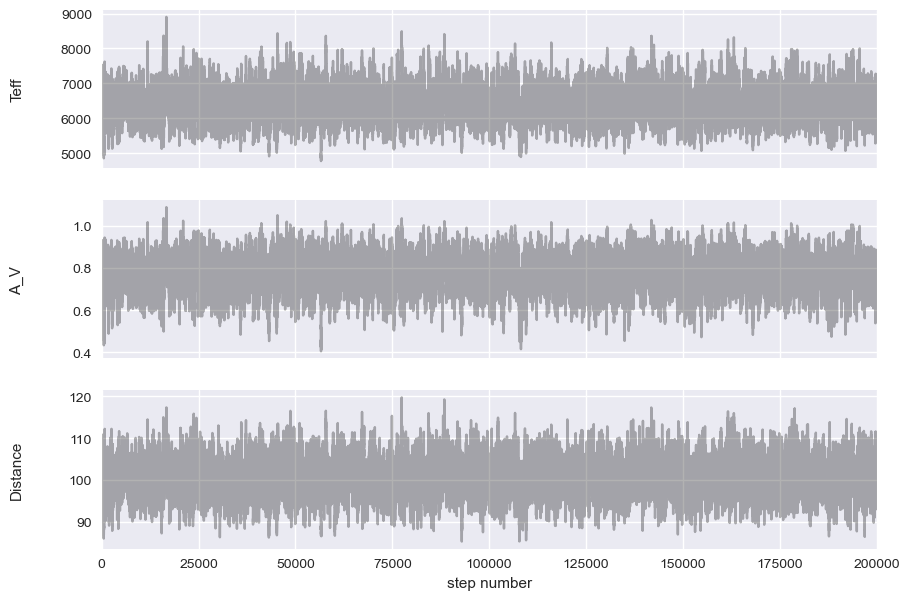

In [18]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)

labels = ["Teff", "A_V", "Distance"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_all[ :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_all))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [19]:
def print_res(samples, label):
    median_temp = np.median(samples[:,0])
    median_av = np.median(samples[:,1])
    median_dist = np.median(samples[:,2])
    mc_errors = [np.std(samples[:,0]), np.std(samples[:,1]), np.std(samples[:,2])]

    print(f"Emcee results {label}:")
    print(f"Fitted temperature: {median_temp:.1f} K  +/- {mc_errors[0]:.1f} K (true: {TRUE_TEMP} K)")
    print(f"Fitted A_V: {median_av:.3f} mag +/- {mc_errors[1]:.3f} mag (true: {TRUE_A_V} mag)")
    print(f"Fitted Distance: {median_dist:.2f} pc +/- {mc_errors[2]:.2f} pc (true: {TRUE_DISTANCE} mag)")

In [20]:
print_res(samples_all, 'All')
print("-"*60)
print_res(samples_rijhk, 'RIJHK')
print("-"*60)
print_res(samples_bvr, 'BVR')
print("-"*60)

Emcee results All:
Fitted temperature: 6381.4 K  +/- 515.0 K (true: 6500 K)
Fitted A_V: 0.775 mag +/- 0.089 mag (true: 0.8 mag)
Fitted Distance: 100.48 pc +/- 4.49 pc (true: 100 mag)
------------------------------------------------------------
Emcee results RIJHK:
Fitted temperature: 6312.9 K  +/- 519.3 K (true: 6500 K)
Fitted A_V: 0.778 mag +/- 0.092 mag (true: 0.8 mag)
Fitted Distance: 99.19 pc +/- 4.92 pc (true: 100 mag)
------------------------------------------------------------
Emcee results BVR:
Fitted temperature: 6499.6 K  +/- 855.2 K (true: 6500 K)
Fitted A_V: 0.804 mag +/- 0.161 mag (true: 0.8 mag)
Fitted Distance: 99.57 pc +/- 4.53 pc (true: 100 mag)
------------------------------------------------------------


In [21]:
print_res(samples_all_nogaia, 'All no Gaia')
print("-"*60)
print_res(samples_rijhk_nogaia, 'RIJHK no Gaia')
print("-"*60)
print_res(samples_bvr_nogaia, 'BVR no Gaia')
print("-"*60)

Emcee results All no Gaia:
Fitted temperature: 8422.3 K  +/- 2050.2 K (true: 6500 K)
Fitted A_V: 1.020 mag +/- 0.179 mag (true: 0.8 mag)
Fitted Distance: 118.25 pc +/- 15.90 pc (true: 100 mag)
------------------------------------------------------------
Emcee results RIJHK no Gaia:
Fitted temperature: 28661.1 K  +/- 13660.9 K (true: 6500 K)
Fitted A_V: 1.403 mag +/- 0.232 mag (true: 0.8 mag)
Fitted Distance: 242.58 pc +/- 71.39 pc (true: 100 mag)
------------------------------------------------------------
Emcee results BVR no Gaia:
Fitted temperature: 8690.3 K  +/- 5421.8 K (true: 6500 K)
Fitted A_V: 1.070 mag +/- 0.340 mag (true: 0.8 mag)
Fitted Distance: 114.85 pc +/- 28.21 pc (true: 100 mag)
------------------------------------------------------------


In [22]:
from chainconsumer import ChainConsumer, Chain, Truth
import pandas

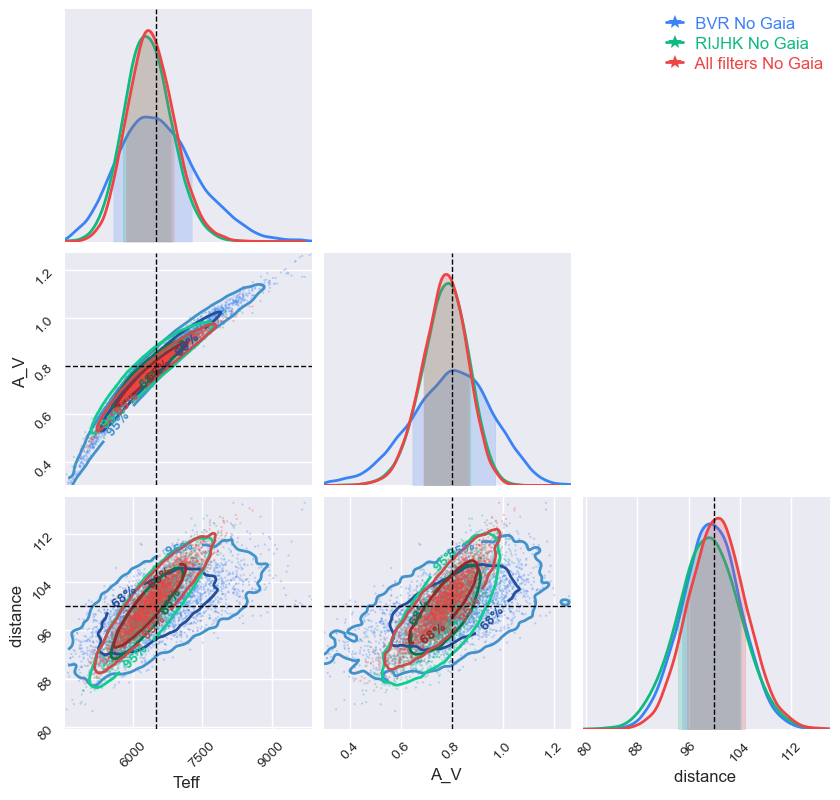

In [23]:
c = ChainConsumer()
df_all = pd.DataFrame({'Teff':samples_all[:,0], 'A_V': samples_all[:, 1], 'distance':samples_all[:,2]})
df_rijhk = pd.DataFrame({'Teff':samples_rijhk[:,0], 'A_V': samples_rijhk[:, 1], 'distance':samples_rijhk[:,2]})
df_bvr = pd.DataFrame({'Teff':samples_bvr[:,0], 'A_V': samples_bvr[:, 1], 'distance':samples_bvr[:,2]})



c.add_chain(Chain(samples=df_bvr, name="BVR No Gaia", plot_point=True,
    plot_cloud=True,
    marker_style="*",
    marker_size=100,
    num_cloud=3000,
    shade=False,
    linewidth=2.0,
    show_contour_labels=True,))

c.add_chain(Chain(samples=df_rijhk, name="RIJHK No Gaia", plot_point=True,
    plot_cloud=True,
    marker_style="*",
    marker_size=100,
    num_cloud=3000,
    shade=False,
    linewidth=2.0,
    show_contour_labels=True,))

c.add_chain(Chain(samples=df_all, name="All filters No Gaia", plot_point=True,
    plot_cloud=True,
    marker_style="*",
    marker_size=100,
    num_cloud=3000,
    shade=False,
    linewidth=2.0,
    show_contour_labels=True,))
c.add_truth(Truth(location={'Teff': TRUE_TEMP, "A_V": TRUE_A_V, "distance":TRUE_DISTANCE}))
fig = c.plotter.plot()

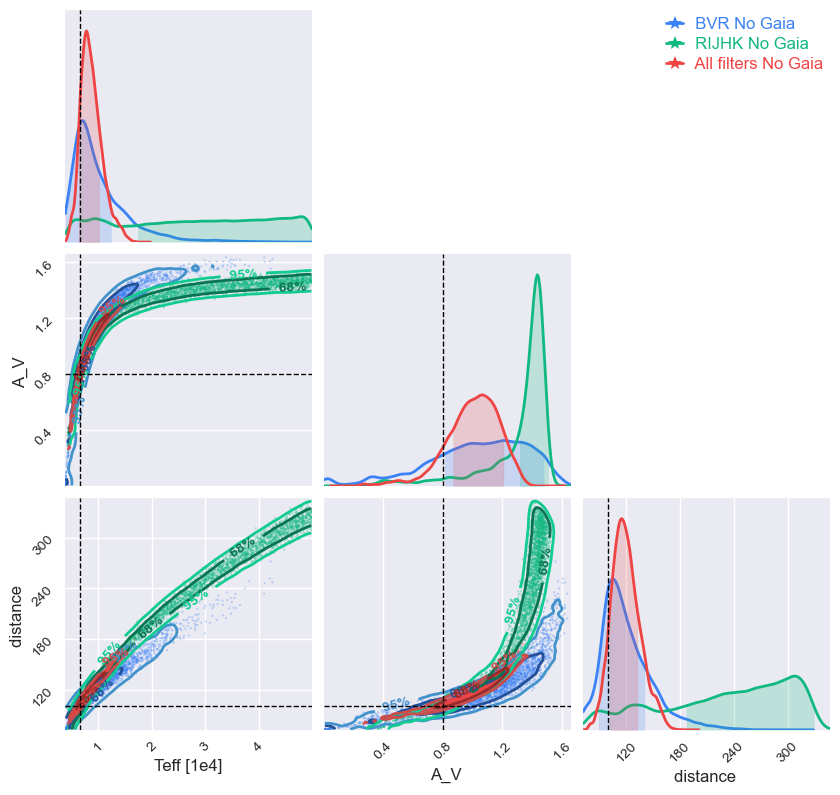

In [24]:
c = ChainConsumer()
df_all = pd.DataFrame({'Teff':samples_all_nogaia[:,0], 'A_V': samples_all_nogaia[:, 1], 'distance':samples_all_nogaia[:,2]})
df_rijhk = pd.DataFrame({'Teff':samples_rijhk_nogaia[:,0], 'A_V': samples_rijhk_nogaia[:, 1], 'distance':samples_rijhk_nogaia[:,2]})
df_bvr = pd.DataFrame({'Teff':samples_bvr_nogaia[:,0], 'A_V': samples_bvr_nogaia[:, 1], 'distance':samples_bvr_nogaia[:,2]})


c.add_chain(Chain(samples=df_bvr, name="BVR No Gaia", plot_point=True,
    plot_cloud=True,
    marker_style="*",
    marker_size=100,
    num_cloud=3000,
    shade=False,
    linewidth=2.0,
    show_contour_labels=True,))

c.add_chain(Chain(samples=df_rijhk, name="RIJHK No Gaia", plot_point=True,
    plot_cloud=True,
    marker_style="*",
    marker_size=100,
    num_cloud=3000,
    shade=False,
    linewidth=2.0,
    show_contour_labels=True,))

c.add_chain(Chain(samples=df_all, name="All filters No Gaia", plot_point=True,
    plot_cloud=True,
    marker_style="*",
    marker_size=100,
    num_cloud=3000,
    shade=False,
    linewidth=2.0,
    show_contour_labels=True,))
c.add_truth(Truth(location={'Teff': TRUE_TEMP, "A_V": TRUE_A_V, "distance":TRUE_DISTANCE}))
fig = c.plotter.plot()

### You can see just how much of an impact the prior makes - without it, as you take away the bluer bands where the extinction is strongest, it is possible to make the star higher temperature, while also making it higher extinction, and higher distance. Increasing the temperature makes the star bluer and brighter, adding extinction makes it redder again, and increasing the distance makes it fainter, so the effects can cancel out the increase in the temperature. 